In [ ]:
# Daron Assadourian
# John Pesanello
# Michael Damsky

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Imports go here
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import seaborn as sns

In [ ]:
# Connect to the file
con = sqlite3.connect("/content/drive/MyDrive/Data144/database.sqlite")

# Load the data into DataFrames
country = pd.read_sql_query("SELECT * from Country", con)
league = pd.read_sql_query("SELECT * from League", con)
match = pd.read_sql_query("SELECT * from Match", con)
player = pd.read_sql_query("SELECT * from Player", con)
player_attributes = pd.read_sql_query("SELECT * from Player_Attributes", con)
team = pd.read_sql_query("SELECT * from Team", con)
team_attributes = pd.read_sql_query("SELECT * from Team_Attributes", con)

In [ ]:
country

,id,name
0,1,Belgium
1,1729,England
2,4769,France
3,7809,Germany
4,10257,Italy
5,13274,Netherlands
6,15722,Poland
7,17642,Portugal
8,19694,Scotland
9,21518,Spain


In [ ]:
league.head()

,id,country_id,name
0,1,1,Belgium Jupiler League
1,1729,1729,England Premier League
2,4769,4769,France Ligue 1
3,7809,7809,Germany 1. Bundesliga
4,10257,10257,Italy Serie A


In [ ]:
match.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_player_X1,home_player_X2,home_player_X3,home_player_X4,home_player_X5,home_player_X6,home_player_X7,home_player_X8,home_player_X9,home_player_X10,home_player_X11,away_player_X1,away_player_X2,away_player_X3,away_player_X4,away_player_X5,away_player_X6,away_player_X7,away_player_X8,away_player_X9,away_player_X10,away_player_X11,home_player_Y1,home_player_Y2,home_player_Y3,home_player_Y4,home_player_Y5,home_player_Y6,home_player_Y7,...,away_player_10,away_player_11,goal,shoton,shotoff,foulcommit,card,cross,corner,possession,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,LBH,LBD,LBA,PSH,PSD,PSA,WHH,WHD,WHA,SJH,SJD,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,None,None,None,None,None,None,None,None,1.73,3.40,5.00,1.75,3.35,4.20,1.85,3.2,3.5,1.80,3.3,3.75,NaN,NaN,NaN,1.70,3.30,4.33,1.90,3.3,4.00,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,None,None,None,None,None,None,None,None,1.95,3.20,3.60,1.80,3.30,3.95,1.90,3.2,3.5,1.90,3.2,3.50,NaN,NaN,NaN,1.83,3.30,3.60,1.95,3.3,3.80,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,None,None,None,None,None,None,None,None,2.38,3.30,2.75,2.40,3.30,2.55,2.60,3.1,2.3,2.50,3.2,2.50,NaN,NaN,NaN,2.50,3.25,2.40,2.63,3.3,2.50,2.35,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75
3,4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,None,None,None,None,None,None,None,None,1.44,3.75,7.50,1.40,4.00,6.80,1.40,3.9,6.0,1.44,3.6,6.50,NaN,NaN,NaN,1.44,3.75,6.00,1.44,4.0,7.50,1.45,3.75,6.50,1.50,3.75,5.50,1.44,3.75,6.50
4,5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,None,None,None,None,None,None,None,None,5.00,3.50,1.65,5.00,3.50,1.60,4.00,3.3,1.7,4.00,3.4,1.72,NaN,NaN,NaN,4.20,3.40,1.70,4.50,3.5,1.73,4.50,3.40,1.65,4.50,3.50,1.65,4.75,3.30,1.67


In [ ]:
player.head()
len(player)

11060

In [ ]:
player_attributes.head()
len(player_attributes)

183978

In [ ]:
combined_player = player.merge(player_attributes, on='player_api_id', how='inner')
combined_player.head()
combined_player['date'] = pd.to_datetime(combined_player['date'])
combined_player['birthday'] = pd.to_datetime(combined_player['birthday'])
combined_player['age'] = (combined_player['date'] - combined_player['birthday']).astype(int) / 1000000000 / 60 / 60 / 24 / 365.2425
combined_player = combined_player[combined_player['age'] >= 21]
len(combined_player)

153863

In [ ]:
combined_player.head()

,id_x,player_api_id,player_name,player_fifa_api_id_x,birthday,height,weight,id_y,player_fifa_api_id_y,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,age
0,1,505942,Aaron Appindangoye,218353,1992-02-29,182.88,187,1,218353,2016-02-18,67.0,71.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,71.0,70.0,45.0,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0,23.970376
1,1,505942,Aaron Appindangoye,218353,1992-02-29,182.88,187,2,218353,2015-11-19,67.0,71.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,71.0,70.0,45.0,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0,23.721226
2,1,505942,Aaron Appindangoye,218353,1992-02-29,182.88,187,3,218353,2015-09-21,62.0,66.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,63.0,41.0,45.0,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0,23.559690
3,1,505942,Aaron Appindangoye,218353,1992-02-29,182.88,187,4,218353,2015-03-20,61.0,65.0,right,medium,medium,48.0,43.0,70.0,60.0,43.0,50.0,44.0,38.0,63.0,48.0,60.0,64.0,59.0,46.0,65.0,54.0,58.0,54.0,76.0,34.0,62.0,40.0,44.0,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0,23.053177
5,2,155782,Aaron Cresswell,189615,1989-12-15,170.18,146,6,189615,2016-04-21,74.0,76.0,left,high,medium,80.0,53.0,58.0,71.0,40.0,73.0,70.0,69.0,68.0,71.0,79.0,78.0,78.0,67.0,90.0,71.0,85.0,79.0,56.0,62.0,68.0,67.0,60.0,66.0,59.0,76.0,75.0,78.0,14.0,7.0,9.0,9.0,12.0,26.349617


In [ ]:
peak = combined_player[['player_api_id', 'overall_rating']].groupby('player_api_id').max().reset_index()
peak.columns = ['player_api_id', 'peak_rating']

In [ ]:
combined_player = combined_player.merge(peak, on='player_api_id', how='inner')

In [ ]:
combined_player.head()

,id_x,player_api_id,player_name,player_fifa_api_id_x,birthday,height,weight,id_y,player_fifa_api_id_y,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,age,peak_rating
0,1,505942,Aaron Appindangoye,218353,1992-02-29,182.88,187,1,218353,2016-02-18,67.0,71.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,71.0,70.0,45.0,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0,23.970376,67.0
1,1,505942,Aaron Appindangoye,218353,1992-02-29,182.88,187,2,218353,2015-11-19,67.0,71.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,71.0,70.0,45.0,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0,23.721226,67.0
2,1,505942,Aaron Appindangoye,218353,1992-02-29,182.88,187,3,218353,2015-09-21,62.0,66.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,63.0,41.0,45.0,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0,23.559690,67.0
3,1,505942,Aaron Appindangoye,218353,1992-02-29,182.88,187,4,218353,2015-03-20,61.0,65.0,right,medium,medium,48.0,43.0,70.0,60.0,43.0,50.0,44.0,38.0,63.0,48.0,60.0,64.0,59.0,46.0,65.0,54.0,58.0,54.0,76.0,34.0,62.0,40.0,44.0,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0,23.053177,67.0
4,2,155782,Aaron Cresswell,189615,1989-12-15,170.18,146,6,189615,2016-04-21,74.0,76.0,left,high,medium,80.0,53.0,58.0,71.0,40.0,73.0,70.0,69.0,68.0,71.0,79.0,78.0,78.0,67.0,90.0,71.0,85.0,79.0,56.0,62.0,68.0,67.0,60.0,66.0,59.0,76.0,75.0,78.0,14.0,7.0,9.0,9.0,12.0,26.349617,74.0


In [ ]:
np.mean(combined_player[combined_player['overall_rating'] == combined_player['peak_rating']]['age'])

26.284797927700172

In [ ]:
long_career = combined_player[combined_player['birthday'] < '1987-01-01']
younger_players = combined_player[combined_player['birthday'] >= '1987-01-01']
len(long_career), len(younger_players)

(82356, 71507)

In [ ]:
np.mean(long_career[long_career['overall_rating'] == long_career['peak_rating']]['age'])

28.815971184546985

In [ ]:
from sklearn.linear_model import LinearRegression
features_list = ['height', 'weight', 'overall_rating', 'potential',
                  'crossing', 'finishing', 'heading_accuracy',
                  'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy',
                  'long_passing', 'ball_control', 'acceleration', 'sprint_speed',
                  'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina',
                  'strength', 'long_shots', 'aggression', 'interceptions', 'positioning',
                  'vision', 'penalties', 'marking', 'standing_tackle', 'sliding_tackle',
                  'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning',
                  'gk_reflexes', 'age']
long_career = long_career.dropna(axis=0)
younger_players = younger_players.dropna(axis=0)
X_train = long_career[features_list]
y_train = long_career['peak_rating']
X_test = younger_players[features_list]
y_test = younger_players['peak_rating']

In [ ]:
linreg = LinearRegression().fit(X_train, y_train)

In [ ]:
younger_players['predicted_peak'] = linreg.predict(X_test)
younger_players['difference'] = np.abs(younger_players['predicted_peak'] - younger_players['peak_rating'])
younger_players.head(10)

,id_x,player_api_id,player_name,player_fifa_api_id_x,birthday,height,weight,id_y,player_fifa_api_id_y,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,age,peak_rating,predicted_peak,difference
0,1,505942,Aaron Appindangoye,218353,1992-02-29,182.88,187,1,218353,2016-02-18,67.0,71.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,71.0,70.0,45.0,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0,23.970376,67.0,72.304690,5.304690
1,1,505942,Aaron Appindangoye,218353,1992-02-29,182.88,187,2,218353,2015-11-19,67.0,71.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,71.0,70.0,45.0,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0,23.721226,67.0,72.262888,5.262888
2,1,505942,Aaron Appindangoye,218353,1992-02-29,182.88,187,3,218353,2015-09-21,62.0,66.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,63.0,41.0,45.0,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0,23.559690,67.0,68.577268,1.577268
3,1,505942,Aaron Appindangoye,218353,1992-02-29,182.88,187,4,218353,2015-03-20,61.0,65.0,right,medium,medium,48.0,43.0,70.0,60.0,43.0,50.0,44.0,38.0,63.0,48.0,60.0,64.0,59.0,46.0,65.0,54.0,58.0,54.0,76.0,34.0,62.0,40.0,44.0,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0,23.053177,67.0,67.678434,0.678434
4,2,155782,Aaron Cresswell,189615,1989-12-15,170.18,146,6,189615,2016-04-21,74.0,76.0,left,high,medium,80.0,53.0,58.0,71.0,40.0,73.0,70.0,69.0,68.0,71.0,79.0,78.0,78.0,67.0,90.0,71.0,85.0,79.0,56.0,62.0,68.0,67.0,60.0,66.0,59.0,76.0,75.0,78.0,14.0,7.0,9.0,9.0,12.0,26.349617,74.0,75.807526,1.807526
5,2,155782,Aaron Cresswell,189615,1989-12-15,170.18,146,7,189615,2016-04-07,74.0,76.0,left,high,medium,80.0,53.0,58.0,71.0,32.0,73.0,70.0,69.0,68.0,71.0,79.0,78.0,78.0,67.0,90.0,71.0,85.0,79.0,56.0,60.0,68.0,67.0,60.0,66.0,59.0,76.0,75.0,78.0,14.0,7.0,9.0,9.0,12.0,26.311286,74.0,75.528029,1.528029
6,2,155782,Aaron Cresswell,189615,1989-12-15,170.18,146,8,189615,2016-01-07,73.0,75.0,left,high,medium,79.0,52.0,57.0,70.0,29.0,71.0,68.0,69.0,68.0,70.0,79.0,78.0,78.0,67.0,90.0,71.0,84.0,79.0,56.0,59.0,67.0,66.0,58.0,65.0,59.0,76.0,75.0,78.0,14.0,7.0,9.0,9.0,12.0,26.062137,74.0,74.585569,0.585569
7,2,155782,Aaron Cresswell,189615,1989-12-15,170.18,146,9,189615,2015-12-24,73.0,75.0,left,high,medium,79.0,51.0,57.0,70.0,29.0,71.0,68.0,69.0,68.0,70.0,79.0,78.0,78.0,67.0,90.0,71.0,84.0,79.0,56.0,58.0,67.0,66.0,58.0,65.0,59.0,76.0,75.0,78.0,14.0,7.0,9.0,9.0,12.0,26.023806,74.0,74.612660,0.612660
8,2,155782,Aaron Cresswell,189615,1989-12-15,170.18,146,10,189615,2015-12-17,73.0,75.0,left,high,medium,79.0,51.0,57.0,70.0,29.0,71.0,68.0,69.0,68.0,70.0,79.0,78.0,78.0,67.0,90.0,71.0,84.0,79.0,56.0,58.0,67.0,66.0,58.0,65.0,59.0,76.0,75.0,78.0,14.0,7.0,9.0,9.0,12.0,26.004641,74.0,74.609445,0.609445
9,2,155782,Aaron Cresswell,189615,1989-12-15,170.18,146,11,189615,2015-10-16,73.0,77.0,left,high,medium,79.0,51.0,57.0,70.0,29.0,71.0,68.0,69.0,68.0,70.0,79.0,78.0,78.0,67.0,90.0,71.0,84.0,79.0,56.0,58.0,67.0,66.0,58.0,65.0,59.0,76.0,75.0,78.0,14.0,7.0,9.0,9.0,12.0,25.834891,74.0,75.022972,1.022972


In [ ]:
np.mean(younger_players['difference']**2)**.5

3.175504759621006

In [ ]:
np.mean(younger_players['difference'])

2.4984153877637643

In [ ]:
younger_players['within2'] = np.where(younger_players['difference'] <= 4, 1, 0)
sum(younger_players['within2'])/len(younger_players)

0.8078540195089136

In [ ]:
early_careers = long_career[long_career['age'] < 28]
X_early = early_careers[features_list]
y_early = early_careers['peak_rating']
early_careers['predicted_peak'] = linreg.predict(X_early)
early_careers['difference'] = np.abs(early_careers['predicted_peak'] - early_careers['peak_rating'])
early_careers.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,id_x,player_api_id,player_name,player_fifa_api_id_x,birthday,height,weight,id_y,player_fifa_api_id_y,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,age,peak_rating,predicted_peak,difference
66,4,30572,Aaron Galindo,140161,1982-05-08,182.88,198,82,140161,2010-02-22,69.0,70.0,right,medium,high,57.0,21.0,70.0,65.0,48.0,56.0,38.0,40.0,61.0,62.0,55.0,61.0,63.0,57.0,45.0,65.0,69.0,49.0,75.0,29.0,69.0,65.0,26.0,54.0,37.0,73.0,71.0,70.0,14.0,11.0,12.0,11.0,10.0,27.795232,75.0,74.714675,0.285325
67,4,30572,Aaron Galindo,140161,1982-05-08,182.88,198,83,140161,2009-08-30,74.0,78.0,right,medium,high,59.0,43.0,73.0,71.0,48.0,59.0,38.0,42.0,64.0,70.0,75.0,75.0,63.0,64.0,45.0,67.0,69.0,72.0,72.0,33.0,71.0,65.0,78.0,54.0,59.0,78.0,76.0,70.0,14.0,11.0,64.0,11.0,10.0,27.313360,75.0,76.475767,1.475767
68,4,30572,Aaron Galindo,140161,1982-05-08,182.88,198,84,140161,2009-02-22,75.0,82.0,right,medium,high,60.0,44.0,74.0,72.0,48.0,60.0,38.0,43.0,65.0,71.0,76.0,79.0,63.0,65.0,45.0,68.0,69.0,77.0,70.0,34.0,72.0,66.0,81.0,54.0,60.0,80.0,78.0,70.0,14.0,11.0,65.0,11.0,10.0,26.795896,75.0,77.379698,2.379698
69,4,30572,Aaron Galindo,140161,1982-05-08,182.88,198,85,140161,2008-08-30,73.0,82.0,right,medium,high,60.0,44.0,79.0,60.0,48.0,52.0,38.0,43.0,61.0,69.0,76.0,79.0,63.0,65.0,45.0,68.0,69.0,77.0,68.0,34.0,70.0,54.0,68.0,54.0,60.0,77.0,74.0,70.0,14.0,11.0,61.0,11.0,10.0,26.314024,75.0,76.913270,1.913270
70,4,30572,Aaron Galindo,140161,1982-05-08,182.88,198,86,140161,2007-08-30,71.0,78.0,right,medium,high,58.0,50.0,70.0,60.0,48.0,52.0,38.0,43.0,58.0,66.0,73.0,73.0,63.0,62.0,45.0,65.0,69.0,75.0,68.0,51.0,70.0,54.0,68.0,54.0,60.0,72.0,70.0,70.0,14.0,11.0,58.0,11.0,10.0,25.311950,75.0,74.577016,0.422984


In [ ]:
np.mean(early_careers['difference']**2)**.5

3.37406443826912

In [ ]:
np.mean(early_careers['difference'])

2.541229881985946

In [ ]:
accuracies = []
for age in [23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]:
  early_careers = long_career[long_career['age'] < age]
  X_early = early_careers[features_list]
  y_early = early_careers['peak_rating']
  early_careers['predicted_peak'] = linreg.predict(X_early)
  early_careers['difference'] = np.abs(early_careers['predicted_peak'] - early_careers['peak_rating'])
  early_careers['within2'] = np.where(early_careers['difference'] <= 4, 1, 0)
  accuracies.append(sum(early_careers['within2'])/len(early_careers))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

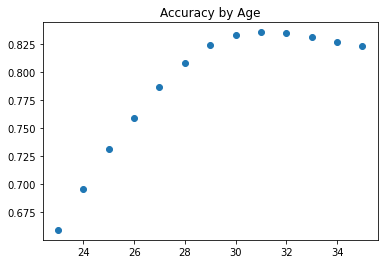

In [ ]:
plt.scatter(x=[23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35], y=accuracies)
plt.title('Accuracy by Age');

In [ ]:
#gets very accurate for age 27 and up
accuracies

[0.6589615931721194,
 0.6956928838951311,
 0.7315630797773655,
 0.7585747846515271,
 0.7860648223049129,
 0.8082580254849321,
 0.8240304864380184,
 0.8328032114418584,
 0.8352610768264291,
 0.8348290912657546,
 0.8309993729658715,
 0.8270032163333799,
 0.8234224598930481]

In [ ]:
early_careers['within2'] = np.where(early_careers['difference'] <= 4, 1, 0)
sum(early_careers['within2'])/len(early_careers)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


0.8234224598930481

In [ ]:
late_careers = long_career[long_career['age'] > 33]
X_late = late_careers[features_list]
y_late = late_careers['peak_rating']
late_careers['predicted_peak'] = linreg.predict(X_late)
late_careers['difference'] = np.abs(late_careers['predicted_peak'] - late_careers['peak_rating'])
late_careers.head(10)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,id_x,player_api_id,player_name,player_fifa_api_id_x,birthday,height,weight,id_y,player_fifa_api_id_y,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,age,peak_rating,predicted_peak,difference
49,4,30572,Aaron Galindo,140161,1982-05-08,182.88,198,65,140161,2016-04-21,69.0,69.0,right,medium,medium,57.0,21.0,68.0,65.0,48.0,56.0,38.0,40.0,61.0,62.0,33.0,34.0,62.0,57.0,41.0,59.0,71.0,49.0,90.0,29.0,70.0,62.0,26.0,54.0,37.0,72.0,71.0,68.0,15.0,12.0,13.0,12.0,11.0,33.955523,75.0,75.757286,0.757286
50,4,30572,Aaron Galindo,140161,1982-05-08,182.88,198,66,140161,2015-10-16,69.0,69.0,right,medium,medium,57.0,21.0,68.0,65.0,48.0,56.0,38.0,40.0,61.0,62.0,33.0,34.0,62.0,57.0,41.0,65.0,71.0,49.0,90.0,29.0,70.0,62.0,26.0,54.0,37.0,72.0,71.0,68.0,15.0,12.0,13.0,12.0,11.0,33.440796,75.0,75.688786,0.688786
51,4,30572,Aaron Galindo,140161,1982-05-08,182.88,198,67,140161,2015-10-02,69.0,69.0,right,medium,medium,57.0,21.0,68.0,65.0,48.0,56.0,38.0,40.0,61.0,62.0,33.0,37.0,62.0,57.0,41.0,65.0,71.0,49.0,87.0,29.0,70.0,62.0,26.0,54.0,37.0,72.0,71.0,68.0,15.0,12.0,13.0,12.0,11.0,33.402465,75.0,75.729422,0.729422
52,4,30572,Aaron Galindo,140161,1982-05-08,182.88,198,68,140161,2015-09-21,69.0,69.0,right,medium,medium,57.0,21.0,68.0,65.0,48.0,56.0,38.0,40.0,61.0,62.0,33.0,37.0,62.0,57.0,41.0,65.0,71.0,49.0,87.0,29.0,70.0,62.0,26.0,54.0,37.0,72.0,71.0,68.0,15.0,12.0,13.0,12.0,11.0,33.372349,75.0,75.724369,0.724369
53,4,30572,Aaron Galindo,140161,1982-05-08,182.88,198,69,140161,2015-07-03,67.0,67.0,right,medium,medium,56.0,20.0,67.0,64.0,47.0,55.0,37.0,39.0,60.0,61.0,37.0,40.0,63.0,56.0,44.0,64.0,73.0,59.0,86.0,28.0,68.0,61.0,25.0,53.0,36.0,66.0,68.0,65.0,14.0,11.0,12.0,11.0,10.0,33.153316,75.0,73.521954,1.478046
54,4,30572,Aaron Galindo,140161,1982-05-08,182.88,198,70,140161,2015-06-12,67.0,67.0,right,medium,medium,56.0,20.0,67.0,64.0,47.0,55.0,37.0,39.0,60.0,61.0,37.0,40.0,63.0,56.0,44.0,64.0,73.0,59.0,86.0,28.0,68.0,61.0,25.0,53.0,36.0,66.0,68.0,65.0,14.0,11.0,12.0,11.0,10.0,33.095820,75.0,73.512307,1.487693
72,5,23780,Aaron Hughes,17725,1979-11-08,182.88,154,88,17725,2015-12-24,70.0,70.0,right,medium,medium,46.0,34.0,73.0,65.0,33.0,47.0,42.0,25.0,58.0,58.0,33.0,31.0,41.0,68.0,52.0,48.0,67.0,60.0,75.0,26.0,66.0,68.0,29.0,41.0,45.0,75.0,73.0,71.0,8.0,6.0,16.0,12.0,11.0,36.126683,78.0,74.903783,3.096217
73,5,23780,Aaron Hughes,17725,1979-11-08,182.88,154,89,17725,2015-09-21,70.0,70.0,right,medium,medium,46.0,34.0,73.0,65.0,33.0,47.0,42.0,25.0,58.0,58.0,33.0,31.0,41.0,68.0,52.0,48.0,67.0,60.0,75.0,26.0,66.0,68.0,29.0,41.0,45.0,75.0,73.0,71.0,8.0,6.0,16.0,12.0,11.0,35.869320,78.0,74.860603,3.139397
74,5,23780,Aaron Hughes,17725,1979-11-08,182.88,154,90,17725,2015-05-08,69.0,69.0,right,medium,medium,45.0,33.0,72.0,64.0,32.0,46.0,41.0,24.0,57.0,57.0,33.0,31.0,45.0,67.0,59.0,47.0,67.0,60.0,74.0,25.0,65.0,67.0,28.0,40.0,44.0,72.0,70.0,68.0,7.0,5.0,15.0,11.0,10.0,35.496964,78.0,74.125772,3.874228
75,5,23780,Aaron Hughes,17725,1979-11-08,182.88,154,91,17725,2015-04-10,69.0,69.0,right,medium,medium,45.0,33.0,72.0,64.0,32.0,46.0,41.0,24.0,57.0,57.0,33.0,31.0,45.0,67.0,59.0,47.0,67.0,60.0,74.0,25.0,65.0,70.0,28.0,40.0,44.0,72.0,70.0,68.0,7.0,5.0,15.0,11.0,10.0,35.420303,78.0,74.106967,3.893033


In [ ]:
late_careers['within2'] = np.where(late_careers['difference'] <= 4, 1, 0)
sum(late_careers['within2'])/len(late_careers)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


0.7292312714215766

In [ ]:
team.head()

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
0,1,9987,673.0,KRC Genk,GEN
1,2,9993,675.0,Beerschot AC,BAC
2,3,10000,15005.0,SV Zulte-Waregem,ZUL
3,4,9994,2007.0,Sporting Lokeren,LOK
4,5,9984,1750.0,KSV Cercle Brugge,CEB


In [ ]:
team_attributes.head()

,id,team_fifa_api_id,team_api_id,date,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,buildUpPlayPositioningClass,chanceCreationPassing,chanceCreationPassingClass,chanceCreationCrossing,chanceCreationCrossingClass,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
0,1,434,9930,2010-02-22 00:00:00,60,Balanced,NaN,Little,50,Mixed,Organised,60,Normal,65,Normal,55,Normal,Organised,50,Medium,55,Press,45,Normal,Cover
1,2,434,9930,2014-09-19 00:00:00,52,Balanced,48.0,Normal,56,Mixed,Organised,54,Normal,63,Normal,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover
2,3,434,9930,2015-09-10 00:00:00,47,Balanced,41.0,Normal,54,Mixed,Organised,54,Normal,63,Normal,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover
3,4,77,8485,2010-02-22 00:00:00,70,Fast,NaN,Little,70,Long,Organised,70,Risky,70,Lots,70,Lots,Organised,60,Medium,70,Double,70,Wide,Cover
4,5,77,8485,2011-02-22 00:00:00,47,Balanced,NaN,Little,52,Mixed,Organised,53,Normal,48,Normal,52,Normal,Organised,47,Medium,47,Press,52,Normal,Cover


In [ ]:
team_attributes.isna()

,id,team_fifa_api_id,team_api_id,date,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,buildUpPlayPositioningClass,chanceCreationPassing,chanceCreationPassingClass,chanceCreationCrossing,chanceCreationCrossingClass,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
0,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1453,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1454,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1455,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1456,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [ ]:
# select players with age between 26 and 31 inclusive , then select all attributes except for age
clustering_table = combined_player[(combined_player['age'] >= 26) & (combined_player['age'] <= 31) ]
clustering_table = clustering_table.groupby('player_name').mean()
clustering_table = clustering_table.loc[: , features_list[:-1] ].dropna()

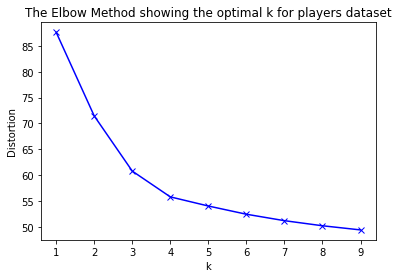

In [ ]:
# k means determine k
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(clustering_table)
    distortions.append(sum(np.min(cdist(clustering_table, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / clustering_table.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k for players dataset')
plt.show()

In [ ]:
elbowModel = KMeans(n_clusters=4)
elbowModel.fit(clustering_table)
elbowModel.cluster_centers_

array([[180.22349707, 165.98507844,  72.0434048 ,  74.45500544,
         67.12728254,  53.55841531,  63.22918245,  72.2326527 ,
         55.75086783,  66.48284818,  62.55182824,  60.6548712 ,
         68.41640519,  71.27947016,  71.07981904,  71.43732203,
         68.68188333,  70.58021001,  69.77587411,  70.27145601,
         69.2971811 ,  77.41920757,  71.01055645,  63.95148276,
         72.16396582,  69.12582657,  65.0118344 ,  67.51010522,
         62.23217961,  64.53236005,  68.93088923,  66.72549363,
          9.95248103,  12.62327519,  26.51937325,  12.61597136,
         12.57021822],
       [184.53841777, 174.52536726,  67.25048598,  69.47301127,
         48.8633382 ,  34.27314237,  65.56706117,  60.08460352,
         35.34039335,  47.88315884,  41.3239482 ,  40.64747925,
         56.01251234,  58.12351377,  61.73539823,  63.32965179,
         57.31726254,  63.3900027 ,  60.55621504,  54.25982584,
         69.04204314,  69.27057224,  74.79450013,  40.90772932,
         70.71512

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 3)
pca.fit(clustering_table)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)
reduced = pca.transform(clustering_table)

[0.49160241 0.20419259 0.0725127 ]
[5383.08972555 3469.32197395 2067.43401469]


In [ ]:
distortions = []
K = range(1,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(reduced)
    distortions.append(sum(np.min(cdist(reduced, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / reduced.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k for reduced data set')
plt.show()

KeyboardInterrupt: ignored

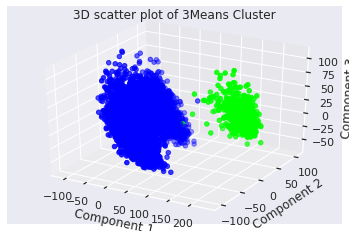

In [ ]:
elbowreduced = KMeans(n_clusters=2 , random_state= 144)
elbowreduced.fit(reduced)
elbowreduced.cluster_centers_

sns.set(style = "darkgrid")

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d' , title = '3D scatter plot of 3Means Cluster')

ax.set_xlabel("Component 1")
ax.set_ylabel("Component 2")
ax.set_zlabel("Component 3")

colormap = plt.cm.brg
ax.scatter(reduced.T[0],reduced.T[1],reduced.T[2] , c = elbowreduced.labels_ , cmap = colormap)

plt.show()
# everything below this is for cs294

# X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33, random_state=42)
df = pd.DataFrame (data = reduced, columns = ['Component 1','Component 2','Component 3'])
df['position'] = elbowreduced.labels_
attackers_temp = df[df['position'] == 0].sample(604)
goalies_temp = df[df['position'] == 1]
combined_temp = pd.concat([attackers_temp, goalies_temp], axis=0).sample(1208)

combined_temp_test = combined_temp.iloc[ : 208 , : ]
combined_temp_train = combined_temp.iloc[208 : , : ]

combined_temp_train.to_csv('players_train.csv')
combined_temp_test.to_csv('players_test.csv')

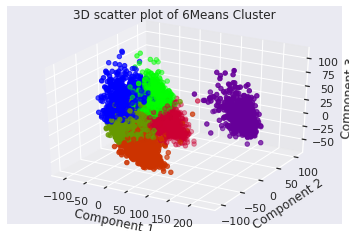

In [ ]:
elbowreduced = KMeans(n_clusters=6 , random_state= 144 )
elbowreduced.fit(reduced)
elbowreduced.cluster_centers_

sns.set(style = "darkgrid")

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d' , title = '3D scatter plot of 6Means Cluster')

ax.set_xlabel("Component 1")
ax.set_ylabel("Component 2")
ax.set_zlabel("Component 3")

colormap = plt.cm.brg
ax.scatter(reduced.T[0],reduced.T[1],reduced.T[2] , c = elbowreduced.labels_ , cmap = colormap)

plt.show()

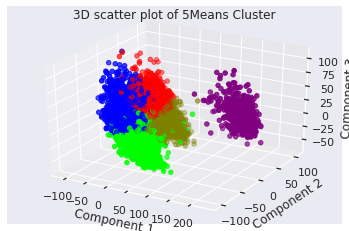

In [ ]:
elbowreduced = KMeans(n_clusters=5 , random_state= 144)
elbowreduced.fit(reduced)
elbowreduced.cluster_centers_

sns.set(style = "darkgrid")

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d' , title = '3D scatter plot of 5Means Cluster')

ax.set_xlabel("Component 1")
ax.set_ylabel("Component 2")
ax.set_zlabel("Component 3")

colormap = plt.cm.brg
ax.scatter(reduced.T[0],reduced.T[1],reduced.T[2] , c = elbowreduced.labels_ , cmap = colormap)

plt.show()

In [ ]:
clustering_table['label'] = elbowreduced.labels_
defending = clustering_table[clustering_table['label'] == 0] # blue
goalkeeper = clustering_table[clustering_table['label'] == 1] # purple
attacking = clustering_table[clustering_table['label'] == 2] # red
bad_attacking = clustering_table[clustering_table['label'] == 3] # gold
bad_defending = clustering_table[clustering_table['label'] == 4] # green 
print(np.mean(bad_attacking['overall_rating']) , np.mean(bad_defending['overall_rating']))
print( np.mean(goalkeeper['overall_rating']) , np.mean(attacking['overall_rating']) , np.mean(defending['overall_rating']) )

66.36550560443176 67.13665980094538
68.78263133286157 75.16435112803264 71.87387099030641


In [ ]:
elbowreduced.cluster_centers_

array([[-39.16988615, -22.58501559,  17.22634263],
       [185.75251342,  25.71841577,  23.54613015],
       [-48.66670853,  49.29827264,   8.00876744],
       [ -9.33774922,  42.69078663, -22.86490824],
       [ 15.38116157, -49.8298673 , -16.33457498]])

In [ ]:
# get cluster labels , go back to original table and give each player their position ( goalie defenders attackers)
# we obtain 

In [ ]:
clustering_table.head()

,height,weight,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,label
player_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Aaron Cresswell,170.18,146.0,73.400000,75.400000,79.400000,52.000000,57.400000,70.400000,31.800000,71.800000,68.800000,69.000000,68.000000,70.400000,79.000000,78.000000,78.000000,67.000000,90.000000,71.000000,84.400000,79.000000,56.000000,59.400000,67.400000,66.400000,58.800000,65.400000,59.000000,76.000000,75.000000,78.000000,14.000000,7.000000,9.000000,9.000000,12.000000,0
Aaron Galindo,182.88,198.0,70.875000,74.000000,58.000000,29.500000,71.750000,66.000000,48.000000,56.375000,38.000000,41.000000,61.875000,65.000000,61.500000,66.000000,63.000000,59.875000,45.000000,66.000000,69.625000,58.625000,73.625000,30.750000,69.750000,63.375000,44.625000,54.000000,45.500000,74.250000,72.875000,70.000000,14.000000,11.000000,31.250000,11.000000,10.000000,4
Aaron Hughes,182.88,154.0,75.000000,79.285714,45.000000,53.571429,75.428571,60.428571,32.000000,57.285714,52.000000,32.142857,56.142857,63.857143,72.428571,74.000000,57.000000,70.000000,76.000000,47.000000,78.000000,77.857143,74.714286,22.142857,76.571429,76.571429,70.857143,60.000000,75.714286,76.571429,80.428571,77.000000,11.285714,16.571429,50.142857,17.285714,16.571429,0
Aaron Hunt,182.88,161.0,78.117647,79.235294,77.000000,72.176471,65.235294,79.764706,77.000000,78.705882,77.529412,74.705882,69.176471,78.235294,76.529412,75.058824,78.058824,79.352941,72.529412,76.588235,68.588235,77.470588,65.588235,76.411765,57.000000,55.294118,77.058824,79.647059,80.764706,32.705882,34.647059,34.294118,14.235294,11.235294,6.235294,15.235294,14.235294,2
Aaron Lennon,165.10,139.0,78.461538,78.769231,78.769231,66.000000,27.153846,77.923077,67.769231,83.153846,62.153846,54.153846,53.153846,81.230769,92.692308,90.076923,93.538462,76.692308,92.000000,61.153846,70.461538,75.769231,52.615385,56.153846,56.153846,36.153846,74.538462,77.615385,61.153846,26.153846,27.000000,27.769231,13.153846,6.153846,6.153846,15.153846,10.153846,2


In [ ]:
#Preparing clustering_table for decision trees
clustering_table['good_attacking'] = np.where(clustering_table['label'] == 2, 1, 0)
clustering_table['bad_defending'] = np.where(clustering_table['label']== 4, 1, 0)
clustering_table['bad_attacking'] = np.where(clustering_table['label'] == 3, 1, 0)
clustering_table['good_defending'] = np.where(clustering_table['label'] == 0, 1, 0)
clustering_table

,height,weight,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,label,good_attacking,bad_defending,bad_attacking,good_defending
player_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Aaron Cresswell,170.18,146.0,73.400000,75.400000,79.400000,52.000000,57.400000,70.400000,31.800000,71.800000,68.800000,69.000000,68.000000,70.400000,79.000000,78.000000,78.000000,67.000000,90.000000,71.000000,84.400000,79.000000,56.000000,59.400000,67.400000,66.400000,58.800000,65.400000,59.000000,76.000000,75.000000,78.000000,14.000000,7.000000,9.000000,9.000000,12.000000,0,0,0,0,1
Aaron Galindo,182.88,198.0,70.875000,74.000000,58.000000,29.500000,71.750000,66.000000,48.000000,56.375000,38.000000,41.000000,61.875000,65.000000,61.500000,66.000000,63.000000,59.875000,45.000000,66.000000,69.625000,58.625000,73.625000,30.750000,69.750000,63.375000,44.625000,54.000000,45.500000,74.250000,72.875000,70.000000,14.000000,11.000000,31.250000,11.000000,10.000000,4,0,1,0,0
Aaron Hughes,182.88,154.0,75.000000,79.285714,45.000000,53.571429,75.428571,60.428571,32.000000,57.285714,52.000000,32.142857,56.142857,63.857143,72.428571,74.000000,57.000000,70.000000,76.000000,47.000000,78.000000,77.857143,74.714286,22.142857,76.571429,76.571429,70.857143,60.000000,75.714286,76.571429,80.428571,77.000000,11.285714,16.571429,50.142857,17.285714,16.571429,0,0,0,0,1
Aaron Hunt,182.88,161.0,78.117647,79.235294,77.000000,72.176471,65.235294,79.764706,77.000000,78.705882,77.529412,74.705882,69.176471,78.235294,76.529412,75.058824,78.058824,79.352941,72.529412,76.588235,68.588235,77.470588,65.588235,76.411765,57.000000,55.294118,77.058824,79.647059,80.764706,32.705882,34.647059,34.294118,14.235294,11.235294,6.235294,15.235294,14.235294,2,1,0,0,0
Aaron Lennon,165.10,139.0,78.461538,78.769231,78.769231,66.000000,27.153846,77.923077,67.769231,83.153846,62.153846,54.153846,53.153846,81.230769,92.692308,90.076923,93.538462,76.692308,92.000000,61.153846,70.461538,75.769231,52.615385,56.153846,56.153846,36.153846,74.538462,77.615385,61.153846,26.153846,27.000000,27.769231,13.153846,6.153846,6.153846,15.153846,10.153846,2,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zsolt Low,180.34,154.0,67.400000,72.800000,62.800000,47.200000,55.400000,67.000000,57.000000,67.200000,60.000000,56.000000,57.400000,68.400000,71.000000,71.800000,59.000000,69.200000,72.000000,61.400000,42.000000,70.000000,66.000000,58.200000,67.600000,70.200000,63.000000,66.000000,61.000000,57.800000,61.600000,59.000000,4.000000,21.000000,57.400000,21.000000,21.000000,0,0,0,0,1
Zurab Khizanishvili,185.42,172.0,68.833333,78.000000,48.000000,43.000000,79.000000,59.000000,59.000000,36.000000,29.000000,37.000000,51.000000,61.000000,63.666667,61.666667,56.000000,62.000000,53.000000,50.000000,68.000000,71.166667,67.000000,46.000000,71.000000,71.666667,53.333333,63.000000,61.666667,68.500000,70.666667,65.000000,14.000000,19.000000,39.000000,20.000000,20.666667,4,0,1,0,0
Zvjezdan Misimovic,180.34,176.0,80.250000,81.875000,79.250000,74.250000,57.500000,85.125000,77.000000,82.000000,86.000000,77.000000,79.875000,83.750000,63.250000,66.625000,78.500000,77.625000,71.875000,76.750000,58.000000,62.000000,65.375000,79.250000,56.125000,45.750000,78.250000,86.875000,75.375000,24.500000,31.000000,30.000000,9.000000,15.625000,33.750000,16.875000,10.625000,2,1,0,0,0


In [ ]:


clustering_table.columns


Index(['height', 'weight', 'overall_rating', 'potential', 'crossing',
       'finishing', 'heading_accuracy', 'short_passing', 'volleys',
       'dribbling', 'curve', 'free_kick_accuracy', 'long_passing',
       'ball_control', 'acceleration', 'sprint_speed', 'agility', 'reactions',
       'balance', 'shot_power', 'jumping', 'stamina', 'strength', 'long_shots',
       'aggression', 'interceptions', 'positioning', 'vision', 'penalties',
       'marking', 'standing_tackle', 'sliding_tackle', 'gk_diving',
       'gk_handling', 'gk_kicking', 'gk_positioning', 'gk_reflexes', 'label',
       'good_attacking', 'bad_defending', 'bad_attacking', 'good_defending'],
      dtype='object')

In [ ]:
#Decision Tree Classifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

y = clustering_table['good_attacking']
X = clustering_table.drop(columns=['good_attacking', 'bad_defending', 'good_defending', 'bad_attacking', 'label', 'potential'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=144)

acc_list_train = []
acc_list_test = []
for i in range(1,11):
  clf = DecisionTreeClassifier(max_depth=i)
  clf = clf.fit(X_train, y_train)
  y_pred_train = clf.predict(X_train)
  y_pred_test = clf.predict(X_test)

  acc_list_train.append(accuracy_score(y_train, y_pred_train))
  acc_list_test.append(accuracy_score(y_test, y_pred_test))

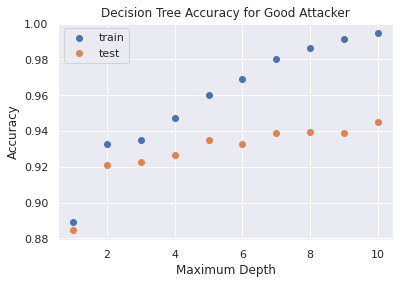

In [ ]:
#visualization attempt, its very large, feel free to try to make it smaller.

#import matplotlib.pyplot as plt
#from sklearn import tree

#clf2 = tree.DecisionTreeClassifier()
#clf2 = clf2.fit(X, y)
#fig, ax = plt.subplots(figsize=(28, 28))
#tree.plot_tree(clf2.fit(X, y), fontsize=5) 
#plt.show()
plt.scatter(x=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], y= acc_list_train, label = 'train')
plt.scatter(x=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], y= acc_list_test, label= 'test')
plt.legend()
plt.title('Decision Tree Accuracy for Good Attacker')
plt.ylabel('Accuracy')
plt.xlabel('Maximum Depth');

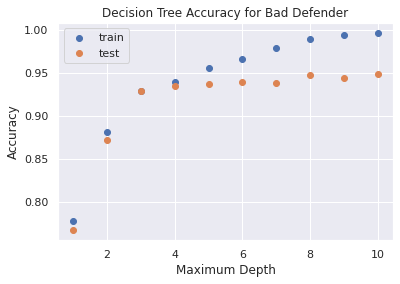

In [ ]:
# Decision Tree Bad Defending

y = clustering_table['bad_defending']
X = clustering_table.drop(columns=['good_attacking', 'bad_defending', 'good_defending', 'bad_attacking', 'label', 'potential'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=144)

acc_list_train2 = []
acc_list_test2 = []
for i in range(1,11):
  clf = DecisionTreeClassifier(max_depth=i)
  clf = clf.fit(X_train, y_train)
  y_pred_train = clf.predict(X_train)
  y_pred_test = clf.predict(X_test)

  acc_list_train2.append(accuracy_score(y_train, y_pred_train))
  acc_list_test2.append(accuracy_score(y_test, y_pred_test))

plt.scatter(x=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], y= acc_list_train2, label = 'train')
plt.scatter(x=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], y= acc_list_test2, label= 'test')
plt.legend()
plt.title('Decision Tree Accuracy for Bad Defender')
plt.ylabel('Accuracy')
plt.xlabel('Maximum Depth');

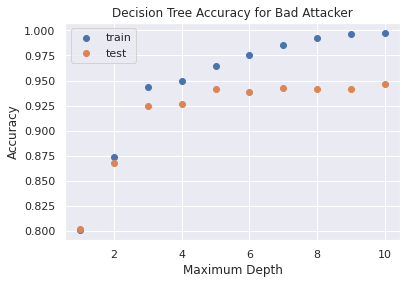

In [ ]:
# Decision Tree Bad Attacking

y = clustering_table['bad_attacking']
X = clustering_table.drop(columns=['good_attacking', 'bad_defending', 'good_defending', 'bad_attacking', 'label', 'potential'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=144)

acc_list_train3 = []
acc_list_test3 = []
for i in range(1,11):
  clf = DecisionTreeClassifier(max_depth=i)
  clf = clf.fit(X_train, y_train)
  y_pred_train = clf.predict(X_train)
  y_pred_test = clf.predict(X_test)

  acc_list_train3.append(accuracy_score(y_train, y_pred_train))
  acc_list_test3.append(accuracy_score(y_test, y_pred_test))

plt.scatter(x=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], y= acc_list_train3, label = 'train')
plt.scatter(x=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], y= acc_list_test3, label= 'test')
plt.legend()
plt.title('Decision Tree Accuracy for Bad Attacker')
plt.ylabel('Accuracy')
plt.xlabel('Maximum Depth');

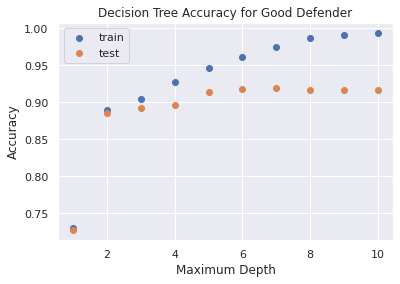

In [ ]:
# Decision Tree Good Defending

y = clustering_table['good_defending']
X = clustering_table.drop(columns=['good_attacking', 'bad_defending', 'good_defending', 'bad_attacking', 'label', 'potential'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=144)

acc_list_train4 = []
acc_list_test4 = []
for i in range(1,11):
  clf = DecisionTreeClassifier(max_depth=i)
  clf = clf.fit(X_train, y_train)
  y_pred_train = clf.predict(X_train)
  y_pred_test = clf.predict(X_test)

  acc_list_train4.append(accuracy_score(y_train, y_pred_train))
  acc_list_test4.append(accuracy_score(y_test, y_pred_test))

plt.scatter(x=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], y= acc_list_train4, label = 'train')
plt.scatter(x=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], y= acc_list_test4, label= 'test')
plt.legend()
plt.title('Decision Tree Accuracy for Good Defender')
plt.ylabel('Accuracy')
plt.xlabel('Maximum Depth');